# SO MANY TS DIAGRAMS

the adventures of whether or not they'll be an obvious way to distinguish my water masses

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.interpolate import interpn
import matplotlib.colors as colors
import gsw

In [2]:
def get_data(mydata, starttime, endtime):
    salt = mydata.init_salt[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    temp = mydata.init_temp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
#     depth = depthf(mydata.init_z[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]-1.)[0]
    trans = mydata.init_transp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/(endtime-starttime+1)
    return salt, temp, trans

In [3]:
def line(x1, x2, y1, y2):
    m = (y2 - y1)/(x2 - x1)
    b = y1 - m*x1
    return m, b

In [9]:
mon16 = ['oct16', 'nov16', 'dec16', 'jan17', 'feb17', 'mar17']
mon_len = [31, 30, 31, 31, 28, 31]
h = 3601
win_start = [h, h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24]
win_end = [h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24, h+sum(mon_len)*24-1]

monS = ['apr', 'may', 'jun', 'jul', 'aug', 'sep']
mon_len = [30, 31, 30, 31, 31, 30]
sum_start = [h, h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24]
sum_end = [h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24, h+sum(mon_len)*24-1]

mon17 = ['oct17', 'nov17', 'dec17', 'jan18', 'feb18', 'mar18'] 

# CIOPS TS match?

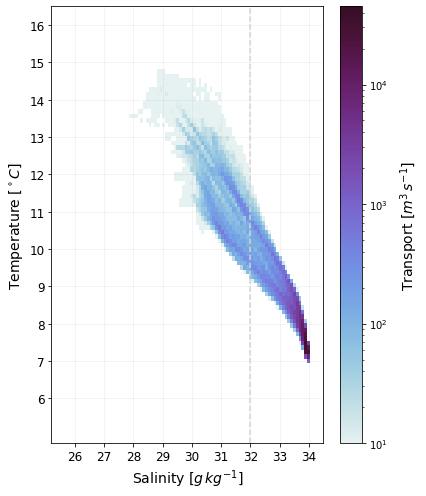

In [5]:
# just summer (june, july, august, september) in one TS diagram
fig, ax = plt.subplots(1,1, figsize=(6,7))
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt, temp, trans = get_data(mydata, sum_start[2], sum_end[-1])

bins = [np.linspace(25.2,34.6,100),np.linspace(4.8,16.6,100)]
# logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X, Y, H_final, cmap=cmap, norm=colors.LogNorm(vmin=10, vmax=45000))
cb = fig.colorbar(im, ax=ax)
cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)
ax.plot([32,32],[4.8, 16.5],ls='dashed',c='lightgrey')
ax.set_ylabel('Temperature [$^\circ C$]', fontsize=14)
ax.set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)
ax.set_yticks(np.arange(6,17,1))
ax.set_yticklabels(np.arange(6,17,1),fontsize=12)
ax.set_xticks(np.arange(26,35,1))
ax.set_xticklabels(np.arange(26,35,1),fontsize=12)
ax.grid(color='gray',alpha=0.1)
ax.set_ylim([4.8, 16.5])
ax.set_xlim([25.2, 34.5])

plt.tight_layout()
plt.savefig("./figures/SummerTS.pdf")

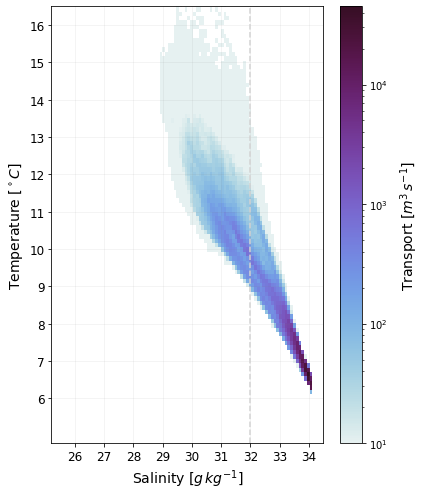

In [6]:
# summer SSC in one TS diagram
# 2017
fig, ax = plt.subplots(1,1, figsize=(6,7))
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
ssc_sum_start = 1+(5*720+(sum(yearjumps[:5+1]*24)))
ssc_sum_end = 720+(8*720+(sum(yearjumps[:8+1]*24)))

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt = mydata.init_salt[(mydata.init_t >= ssc_sum_start) & (mydata.init_t <= ssc_sum_end)]
temp = mydata.init_temp[(mydata.init_t >= ssc_sum_start) & (mydata.init_t <= ssc_sum_end)]
starttime = ssc_sum_start
endtime = ssc_sum_end
trans = mydata.init_transp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/(endtime-starttime+1)

bins = [np.linspace(25.2,34.6,100),np.linspace(4.8,16.6,100)]

H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)#,norm=LogNorm())
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X, Y, H_final, cmap=cmap, norm=colors.LogNorm(vmin=10, vmax=45000))
cb = fig.colorbar(im, ax=ax)
cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)
ax.plot([32,32],[4.8, 16.5],ls='dashed',c='lightgrey')
ax.set_ylabel('Temperature [$^\circ C$]', fontsize=14)
ax.set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)
ax.set_yticks(np.arange(6,17,1))
ax.set_yticklabels(np.arange(6,17,1),fontsize=12)
ax.set_xticks(np.arange(26,35,1))
ax.set_xticklabels(np.arange(26,35,1),fontsize=12)
ax.grid(color='gray',alpha=0.1)
ax.set_ylim([4.8, 16.5])
ax.set_xlim([25.2, 34.5])

plt.tight_layout()
plt.savefig("./figures/SummerSSCTS.pdf")

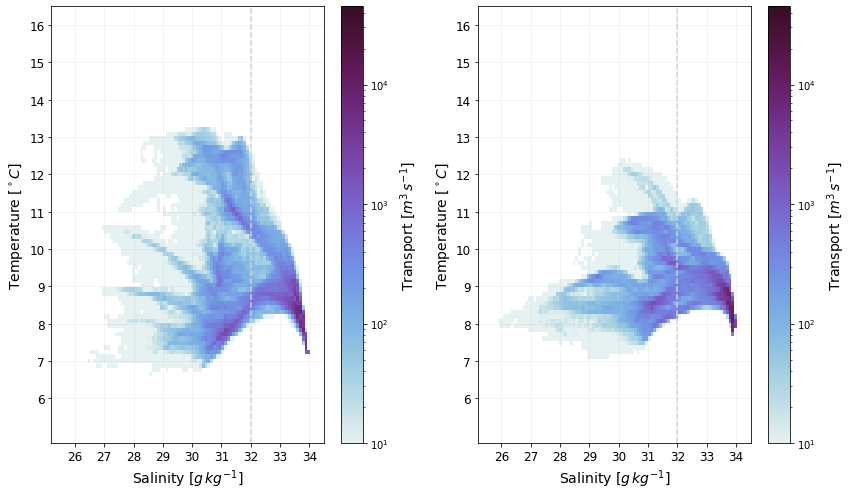

In [8]:
# winters seperately
fig, ax = plt.subplots(1,2, figsize=(12,7))

time = win_end[-1] - win_start[0] + 1 + sum_end[1] - sum_start[0] + 1

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
saltW16 = mydata.init_salt[(mydata.init_t >= win_start[0]) & (mydata.init_t <= win_end[-1])]
tempW16 = mydata.init_temp[(mydata.init_t >= win_start[0]) & (mydata.init_t <= win_end[-1])]
endtime, starttime = win_end[-1], win_start[0]
transW16 = mydata.init_transp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/time

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
saltS = mydata.init_salt[(mydata.init_t >= sum_start[0]) & (mydata.init_t <= sum_end[1])]
tempS = mydata.init_temp[(mydata.init_t >= sum_start[0]) & (mydata.init_t <= sum_end[1])]
endtime, starttime = sum_end[1], sum_start[0]
transS = mydata.init_transp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/time

salt = np.append(saltW16, saltS)
temp = np.append(tempW16, tempS)
trans = np.append(transW16, transS)

bins = [np.linspace(25.2,34.6,100),np.linspace(4.8,16.6,100)]
        
H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)#,norm=LogNorm())
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax[0].pcolormesh(X, Y, H_final, cmap=cmap, norm=colors.LogNorm(vmin=10, vmax=45000))
cb = fig.colorbar(im, ax=ax[0])
cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)
ax[0].plot([32,32],[4.8, 16.5],ls='dashed',c='lightgrey')
ax[0].set_ylabel('Temperature [$^\circ C$]', fontsize=14)
ax[0].set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)
ax[0].set_yticks(np.arange(6,17,1))
ax[0].set_yticklabels(np.arange(6,17,1),fontsize=12)
ax[0].set_xticks(np.arange(26,35,1))
ax[0].set_xticklabels(np.arange(26,35,1),fontsize=12)
ax[0].grid(color='gray',alpha=0.1)
ax[0].set_ylim([4.8, 16.5])
ax[0].set_xlim([25.2, 34.5])

# all winter 2017/18
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt = mydata.init_salt[(mydata.init_t >= win_start[0]) & (mydata.init_t <= win_end[-1])]
temp = mydata.init_temp[(mydata.init_t >= win_start[0]) & (mydata.init_t <= win_end[-1])]

endtime, starttime = win_end[-1], win_start[0]
time = endtime-starttime+1
trans = mydata.init_transp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/time

H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)#,norm=LogNorm())
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax[1].pcolormesh(X, Y, H_final, cmap=cmap, norm=colors.LogNorm(vmin=10, vmax=45000))
cb = fig.colorbar(im, ax=ax[1])
cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)
ax[1].plot([32,32],[4.8, 16.5],ls='dashed',c='lightgrey')
ax[1].set_ylabel('Temperature [$^\circ C$]', fontsize=14)
ax[1].set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)
ax[1].set_yticks(np.arange(6,17,1))
ax[1].set_yticklabels(np.arange(6,17,1),fontsize=12)
ax[1].set_xticks(np.arange(26,35,1))
ax[1].set_xticklabels(np.arange(26,35,1),fontsize=12)
ax[1].grid(color='gray',alpha=0.1)
ax[1].set_ylim([4.8, 16.5])
ax[1].set_xlim([25.2, 34.5])

plt.tight_layout()
# plt.tight_layout()
plt.savefig("./figures/WinterTS.pdf")

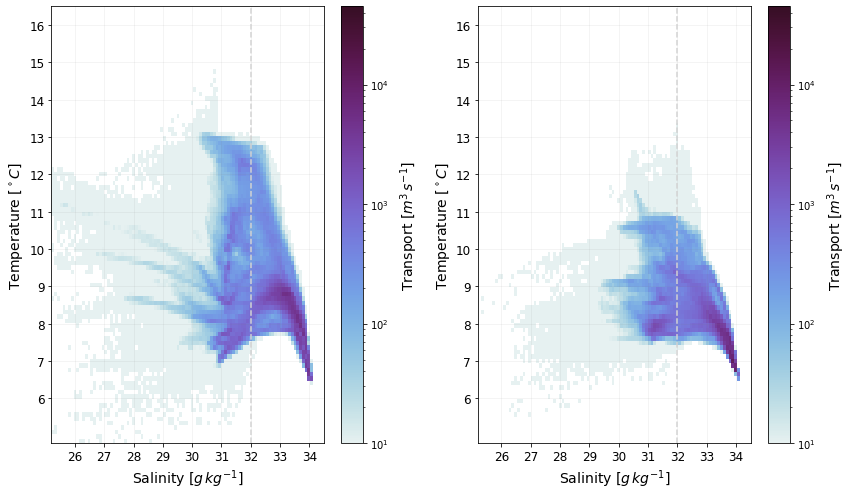

In [9]:
### SSC winters
fig, ax = plt.subplots(1,2, figsize=(12,7))

# 2016/17

yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
ssc_win_start = 1+(9*720+(sum(yearjumps[:9+1]*24)))
ssc_win_end = 720+(11*720+(sum(yearjumps[:11+1]*24)))

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
saltW16 = mydata.init_salt[(mydata.init_t >= ssc_win_start) & (mydata.init_t <= ssc_win_end)]
tempW16 = mydata.init_temp[(mydata.init_t >= ssc_win_start) & (mydata.init_t <= ssc_win_end)]
starttime = ssc_win_start
endtime = ssc_win_end
transW16 = mydata.init_transp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/time

ssc_win_start = 1+(0*720+(sum(yearjumps[:0+1]*24)))
ssc_win_end = 720+(4*720+(sum(yearjumps[:4+1]*24)))

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
saltS = mydata.init_salt[(mydata.init_t >= ssc_win_start) & (mydata.init_t <= ssc_win_end)]
tempS = mydata.init_temp[(mydata.init_t >= ssc_win_start) & (mydata.init_t <= ssc_win_end)]
starttime = ssc_win_start
endtime = ssc_win_end
transS = mydata.init_transp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/time

salt = np.append(saltW16, saltS)
temp = np.append(tempW16, tempS)
trans = np.append(transW16, transS)

bins = [np.linspace(25.2,34.6,100),np.linspace(4.8,16.6,100)]

H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)#,norm=LogNorm())
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax[0].pcolormesh(X, Y, H_final, cmap=cmap, norm=colors.LogNorm(vmin=10, vmax=45000))
cb = fig.colorbar(im, ax=ax[0])
cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)
ax[0].plot([32,32],[4.8, 16.5],ls='dashed',c='lightgrey')
ax[0].set_ylabel('Temperature [$^\circ C$]', fontsize=14)
ax[0].set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)
ax[0].set_yticks(np.arange(6,17,1))
ax[0].set_yticklabels(np.arange(6,17,1),fontsize=12)
ax[0].set_xticks(np.arange(26,35,1))
ax[0].set_xticklabels(np.arange(26,35,1),fontsize=12)
ax[0].grid(color='gray',alpha=0.1)
ax[0].set_ylim([4.8, 16.5])
ax[0].set_xlim([25.2, 34.5])

# 2017/18
# SSC same period
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
ssc_win_start = 1+(9*720+(sum(yearjumps[:9+1]*24)))
ssc_win_end = 720+(11*720+(sum(yearjumps[:11+1]*24)))
time = ssc_win_end - ssc_win_start + 1 + 720*3

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt17 = mydata.init_salt[(mydata.init_t >= ssc_win_start) & (mydata.init_t <= ssc_win_end)]
temp17 = mydata.init_temp[(mydata.init_t >= ssc_win_start) & (mydata.init_t <= ssc_win_end)]
starttime = ssc_win_start
endtime = ssc_win_end
trans17 = mydata.init_transp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/time

start = 1
end = 720

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01jan18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt_jan = mydata.init_salt[(mydata.init_t >= start) & (mydata.init_t <= end)]
temp_jan = mydata.init_temp[(mydata.init_t >= start) & (mydata.init_t <= end)]
trans_jan = mydata.init_transp[(mydata.init_t >= start) & (mydata.init_t <= end)]/time

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01feb18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt_feb = mydata.init_salt[(mydata.init_t >= start) & (mydata.init_t <= end)]
temp_feb = mydata.init_temp[(mydata.init_t >= start) & (mydata.init_t <= end)]
trans_feb = mydata.init_transp[(mydata.init_t >= start) & (mydata.init_t <= end)]/time

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01mar18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt_mar = mydata.init_salt[(mydata.init_t >= start) & (mydata.init_t <= end)]
temp_mar = mydata.init_temp[(mydata.init_t >= start) & (mydata.init_t <= end)]
trans_mar = mydata.init_transp[(mydata.init_t >= start) & (mydata.init_t <= end)]/time

salt = np.append(np.append(np.append(salt17, salt_jan), salt_feb), salt_mar)
temp = np.append(np.append(np.append(temp17, temp_jan), temp_feb), temp_mar)
trans = np.append(np.append(np.append(trans17, trans_jan), trans_feb), trans_mar)

H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)#,norm=LogNorm())
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax[1].pcolormesh(X, Y, H_final, cmap=cmap, norm=colors.LogNorm(vmin=10, vmax=45000))
cb = fig.colorbar(im, ax=ax[1])
cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)
ax[1].plot([32,32],[4.8, 16.5],ls='dashed',c='lightgrey')
ax[1].set_ylabel('Temperature [$^\circ C$]', fontsize=14)
ax[1].set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)
ax[1].set_yticks(np.arange(6,17,1))
ax[1].set_yticklabels(np.arange(6,17,1),fontsize=12)
ax[1].set_xticks(np.arange(26,35,1))
ax[1].set_xticklabels(np.arange(26,35,1),fontsize=12)
ax[1].grid(color='gray',alpha=0.1)
ax[1].set_ylim([4.8, 16.5])
ax[1].set_xlim([25.2, 34.5])

plt.tight_layout()
plt.savefig("./figures/WinterSSCTS.pdf")

<a id=south-shelf-and-CUC-flow></a>
## TS diagrams of south shelf and CUC flow

In [22]:
def get_data_south(mydata, starttime, endtime):
    Sshelf = 5
    Sslope = 4
    # saltdiv = 32
    
    
    salt = mydata.final_salt[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    temp = mydata.final_temp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    trans = mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/(endtime-starttime+1)
    depth = (mydata.final_depth[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]-1.)
    
    return salt, temp, trans, depth

In [5]:
def get_data_south_sep(mydata, starttime, endtime, sdep, deep):
    Sshelf = 5
    Sslope = 4
    saltdiv = 32
    offcut = 595
    
    if deep == False:
        salt = mydata.init_salt[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_depth > sdep) & (mydata.final_x > offcut) & (mydata.init_salt >= saltdiv) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
        temp = mydata.init_temp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_depth > sdep) & (mydata.final_x > offcut) & (mydata.init_salt >= saltdiv) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
        trans = mydata.init_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_depth > sdep) & (mydata.final_x > offcut) & (mydata.init_salt >= saltdiv) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/(endtime-starttime+1)
#         depth = (mydata.final_z[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_depth > sdep) & (mydata.final_x > offcut) & (mydata.init_salt >= saltdiv) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]-1.)
    if deep == True:
        salt = mydata.init_salt[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_depth <= sdep) & (mydata.final_x > offcut) & (mydata.init_salt >= saltdiv) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
        temp = mydata.init_temp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_depth <= sdep) & (mydata.final_x > offcut) & (mydata.init_salt >= saltdiv) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
        trans = mydata.init_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_depth <= sdep) & (mydata.final_x > offcut) & (mydata.init_salt >= saltdiv) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/(endtime-starttime+1)
#         depth = (mydata.final_z[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_depth <= sdep) & (mydata.final_x > offcut) & (mydata.init_salt >= saltdiv) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]-1.)    
    
    return salt, temp, trans

In [25]:
# I want to add lines of constant density to see if there's a correlation between the water masses we see and density
bins = [np.linspace(28, 35.5,100),np.linspace(6, 14,100)]
SA, t = np.meshgrid(bins[0],bins[1])
# don't acutally want the density to be pressure denpendent for this purpose so make artificial P
p = np.array([50 for i in range(np.shape(SA)[0]*np.shape(SA)[1])])
p = p.reshape(100,100)

CT = np.zeros(np.shape(p))
rho = np.zeros(np.shape(p))
spice = np.zeros(np.shape(p))

for i in range(np.shape(p)[0]): 
    CT[i,:] = gsw.CT_from_t(SA[i,:],t[i,:],p[i,:])
    rho[i,:] = gsw.rho_alpha_beta(SA[i,:], CT[i,:], p[i,:])[0]
    spice[i,:] = gsw.spiciness0(SA[i,:], CT[i,:])

In [30]:
def fmt(x):
    x-=1000
    s = f"{x:.0f}"
    return rf"{s}"

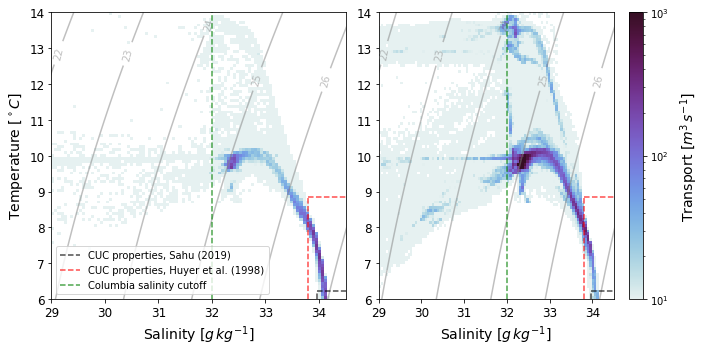

In [44]:
# south only
fig, ax = plt.subplots(1,2, figsize=(10,5))
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt, temp, trans, depth = get_data_south(mydata, sum_start[2], sum_end[-1])

# first coloured by transport
bins = [np.linspace(29,34.6,100),np.linspace(6,14.01,100)]

H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax[0].pcolormesh(X, Y, H_final, cmap=cmap, norm=colors.LogNorm(vmin=10, vmax=1000))
ax[0].set_ylabel('Temperature [$^\circ C$]', fontsize=14)
# cb = fig.colorbar(im, ax=ax[0])
# cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)

# second for winter
time = win_end[-1] - win_start[0] + 1 + sum_end[1] - sum_start[0] + 1

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
saltW16, tempW16, transW16, depthW16 = get_data_south(mydata, win_start[0], win_end[-1])

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
saltS, tempS, transS, depthS = get_data_south(mydata, sum_start[0], sum_end[1])

salt = np.append(saltW16, saltS)
temp = np.append(tempW16, tempS)
trans = np.append(transW16, transS)
depth = np.append(depthW16, depthS)

H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax[1].pcolormesh(X, Y, H_final, cmap=cmap, norm=colors.LogNorm(vmin=10, vmax=1000))
cb = fig.colorbar(im, ax=ax[1])
cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)

for axs in ax:
    CS=axs.contour(SA,t,rho,colors = 'gray', alpha=0.5)
    axs.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
    axs.set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)
    axs.set_yticks(np.arange(6,17,1))
    axs.set_yticklabels(np.arange(6,17,1),fontsize=12)
    axs.set_xticks(np.arange(26,35,1))
    axs.set_xticklabels(np.arange(26,35,1),fontsize=12)
    axs.set_ylim([6, 14])
    axs.set_xlim([29, 34.5])

    # CUC delineations from saurav 2019
    axs.plot([33.96,33.96],[6,6.23],'k--', alpha=0.7, label='CUC properties, Sahu (2019)')
    axs.plot([33.96,34.5],[6.23,6.23],'k--', alpha=0.7)

    # CUC delineation from Huyer 1998
    axs.plot([33.8,33.8],[6,8.85],'r--', alpha=0.7, label='CUC properties, Huyer et al. (1998)')
    axs.plot([33.8,34.5],[8.85,8.85],'r--', alpha=0.7)

    # columbia delineation
    axs.plot([32,32],[6,14],'g--',alpha=0.7,label='Columbia salinity cutoff')

ax[0].legend(loc='lower left')
plt.tight_layout()

<ipython-input-11-11c16b823300>:28: UserWarning: The following kwargs were not used by contour: 'label'
  ax[0].contour(SA,t,spice,colors = 'gray', alpha=0.3,label='Spice')
<ipython-input-11-11c16b823300>:54: UserWarning: The following kwargs were not used by contour: 'label'
  ax[1].contour(SA,t,spice,colors = 'gray', alpha=0.3,label='Spice')


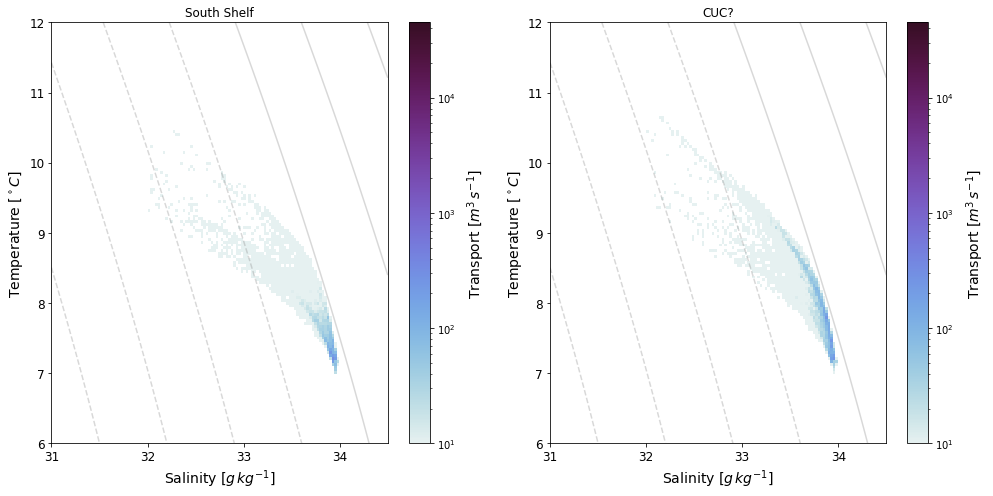

In [11]:
# summer 2017, south shelf and CUC only
fig, ax = plt.subplots(1,2, figsize=(14,7))
time = win_end[-1] - win_start[0] + 1 + sum_end[1] - sum_start[0] + 1
sdep = -100

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt, temp, trans= get_data_south_sep(mydata, sum_start[2], sum_end[-1], sdep, deep=False)

bins = [np.linspace(32,34.6,100),np.linspace(6.9,11,100)]
        
H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)#,norm=LogNorm())
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax[0].pcolormesh(X, Y, H_final, cmap=cmap, norm=colors.LogNorm(vmin=10, vmax=45000))
cb = fig.colorbar(im, ax=ax[0])
cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)
ax[0].set_ylabel('Temperature [$^\circ C$]', fontsize=14)
ax[0].set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)
ax[0].set_yticks(np.arange(6,17,1))
ax[0].set_yticklabels(np.arange(6,17,1),fontsize=12)
ax[0].set_xticks(np.arange(26,35,1))
ax[0].set_xticklabels(np.arange(26,35,1),fontsize=12)
# ax[0].grid(color='gray',alpha=0.1)
ax[0].contour(SA,t,spice,colors = 'gray', alpha=0.3,label='Spice')
ax[0].set_ylim([6, 12])
ax[0].set_xlim([31, 34.5])
ax[0].set_title('South Shelf')

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt, temp, trans= get_data_south_sep(mydata, sum_start[2], sum_end[-1], sdep, deep=True)

bins = [np.linspace(32,34.6,100),np.linspace(6.9,11,100)]
        
H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)#,norm=LogNorm())
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax[1].pcolormesh(X, Y, H_final, cmap=cmap, norm=colors.LogNorm(vmin=10, vmax=45000))
cb = fig.colorbar(im, ax=ax[1])
cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)
ax[1].set_ylabel('Temperature [$^\circ C$]', fontsize=14)
ax[1].set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)
ax[1].set_yticks(np.arange(6,17,1))
ax[1].set_yticklabels(np.arange(6,17,1),fontsize=12)
ax[1].set_xticks(np.arange(26,35,1))
ax[1].set_xticklabels(np.arange(26,35,1),fontsize=12)
ax[1].contour(SA,t,spice,colors = 'gray', alpha=0.3,label='Spice')
# ax[1].grid(color='gray',alpha=0.1)
ax[1].set_ylim([6, 12])
ax[1].set_xlim([31, 34.5])
ax[1].set_title('CUC?')

plt.tight_layout()

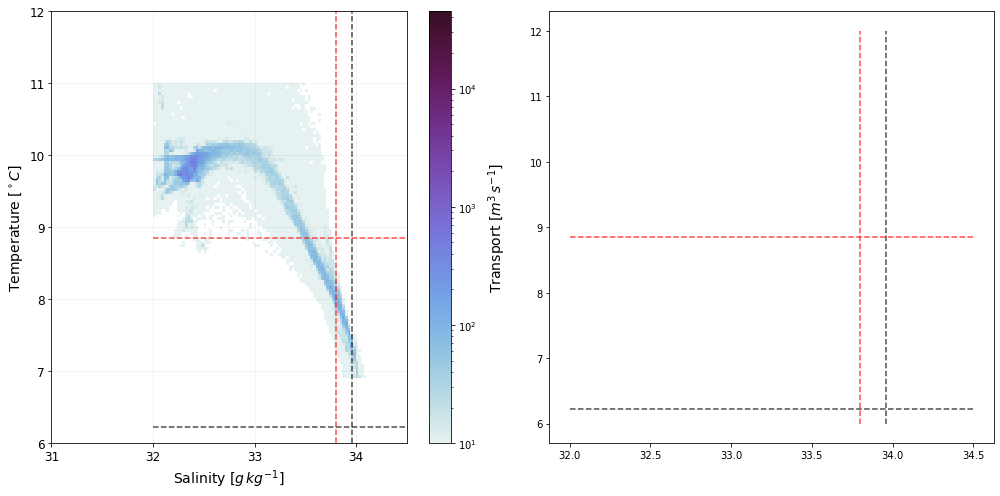

In [21]:
# winter 2016/17
fig, ax = plt.subplots(1,2, figsize=(14,7))
time = win_end[-1] - win_start[0] + 1 + sum_end[1] - sum_start[0] + 1

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
saltW16, tempW16, transW16, depthW16 = get_data_south(mydata, win_start[0], win_end[-1])

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
saltS, tempS, transS, depthS = get_data_south(mydata, sum_start[0], sum_end[1])

salt = np.append(saltW16, saltS)
temp = np.append(tempW16, tempS)
trans = np.append(transW16, transS)
depth = np.append(depthW16, depthS)

bins = [np.linspace(32,34.6,100),np.linspace(6.9,11,100)]
        
H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)#,norm=LogNorm())
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax[0].pcolormesh(X, Y, H_final, cmap=cmap, norm=colors.LogNorm(vmin=10, vmax=45000))
cb = fig.colorbar(im, ax=ax[0])
cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)
ax[0].set_ylabel('Temperature [$^\circ C$]', fontsize=14)
ax[0].set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)
ax[0].set_yticks(np.arange(6,17,1))
ax[0].set_yticklabels(np.arange(6,17,1),fontsize=12)
ax[0].set_xticks(np.arange(26,35,1))
ax[0].set_xticklabels(np.arange(26,35,1),fontsize=12)
ax[0].grid(color='gray',alpha=0.1)
ax[0].set_ylim([6, 12])
ax[0].set_xlim([31, 34.5])

# add some points so we can get the equation for the line seperating the two water masses
# ax[0].scatter([33.55,33.75],[9,8.2])
# x = np.linspace(31,34.5,10)
# y = (-20/9)*x + (676/9) + 8
# ax[0].plot(x,y,'k--')
# # and the even smaller water mass we can see
# x1=33.55
# x2=33.75
# y1=9
# y2=8.2
# m, b = line(x1, x2, y1, y2)

# x = np.linspace(31,33.8,10)
# y=m*x + b
# ax[0].plot(x,y,'r--')


# # second coloured by depth at the boundary
# cmap = cm.cm.deep
# cmap.set_bad('white')
# idx = depth.argsort()
# salt, temp, depth = salt[idx][::-1], temp[idx][::-1], depth[idx][::-1]
# sc=plt.scatter(salt,temp,c=depth, cmap=cmap,s=2, vmin=0, vmax=200)
# cb = fig.colorbar(sc, ax=ax[1])
# cb.set_label('Depth [m]', labelpad=10, fontsize=14)
# ax[1].set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)
# ax[1].set_yticks(np.arange(6,17,1))
# ax[1].set_yticklabels(np.arange(6,17,1),fontsize=12)
# ax[1].set_xticks(np.arange(26,35,1))
# ax[1].set_xticklabels(np.arange(26,35,1),fontsize=12)
# ax[1].grid(color='gray',alpha=0.1)
# ax[1].set_ylim([6, 12])
# ax[1].set_xlim([31, 34.5])



# CUC delineations from saurav 2019
ax[0].plot([33.96,33.96],[6,12],'k--', alpha=0.7)
ax[0].plot([32,34.5],[6.23,6.23],'k--', alpha=0.7)
ax[1].plot([33.96,33.96],[6,12],'k--', alpha=0.7)
ax[1].plot([32,34.5],[6.23,6.23],'k--', alpha=0.7)

# CUC delineation from Huyer 1998
ax[0].plot([33.8,33.8],[6,12],'r--', alpha=0.7)
ax[0].plot([32,34.5],[8.85,8.85],'r--', alpha=0.7)
ax[1].plot([33.8,33.8],[6,12],'r--', alpha=0.7)
ax[1].plot([32,34.5],[8.85,8.85],'r--', alpha=0.7)

plt.tight_layout()

<ipython-input-37-2406c69fac1f>:30: UserWarning: The following kwargs were not used by contour: 'label'
  ax[0].contour(SA,t,spice,colors = 'gray', alpha=0.3,label='Spice')
<ipython-input-37-2406c69fac1f>:67: UserWarning: The following kwargs were not used by contour: 'label'
  ax[1].contour(SA,t,spice,colors = 'gray', alpha=0.3,label='Density')


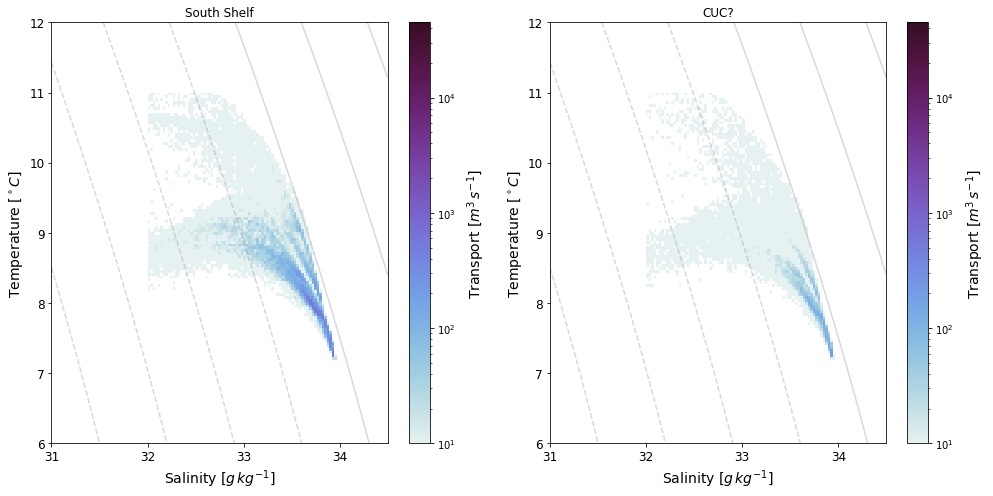

In [37]:
# winter 2016/17, south shelf and CUC only
fig, ax = plt.subplots(1,2, figsize=(14,7))
time = win_end[-1] - win_start[0] + 1 + sum_end[1] - sum_start[0] + 1
sdep = -100

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
saltW16, tempW16, transW16= get_data_south_sep(mydata, win_start[0], win_end[-1], sdep, deep=False)

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
saltS, tempS, transS= get_data_south_sep(mydata, sum_start[0], sum_end[1], sdep, deep=False)

salt = np.append(saltW16, saltS)
temp = np.append(tempW16, tempS)
trans = np.append(transW16, transS)

bins = [np.linspace(32,34.6,100),np.linspace(6.9,11,100)]
        
H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)#,norm=LogNorm())
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax[0].pcolormesh(X, Y, H_final, cmap=cmap, norm=colors.LogNorm(vmin=10, vmax=45000))
cb = fig.colorbar(im, ax=ax[0])
cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)

ax[0].contour(SA,t,spice,colors = 'gray', alpha=0.3,label='Spice')

ax[0].set_ylabel('Temperature [$^\circ C$]', fontsize=14)
ax[0].set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)
ax[0].set_yticks(np.arange(6,17,1))
ax[0].set_yticklabels(np.arange(6,17,1),fontsize=12)
ax[0].set_xticks(np.arange(26,35,1))
ax[0].set_xticklabels(np.arange(26,35,1),fontsize=12)
# ax[0].grid(color='gray',alpha=0.1)
ax[0].set_ylim([6, 12])
ax[0].set_xlim([31, 34.5])
ax[0].set_title('South Shelf')

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
saltW16, tempW16, transW16 = get_data_south_sep(mydata, win_start[0], win_end[-1], sdep, deep=True)

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
saltS, tempS, transS= get_data_south_sep(mydata, sum_start[0], sum_end[1], sdep, deep=True)

salt = np.append(saltW16, saltS)
temp = np.append(tempW16, tempS)
trans = np.append(transW16, transS)

bins = [np.linspace(32,34.6,100),np.linspace(6.9,11,100)]
        
H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)#,norm=LogNorm())
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax[1].pcolormesh(X, Y, H_final, cmap=cmap, norm=colors.LogNorm(vmin=10, vmax=45000))
cb = fig.colorbar(im, ax=ax[1])
cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)

ax[1].contour(SA,t,spice,colors = 'gray', alpha=0.3,label='Density')

ax[1].set_ylabel('Temperature [$^\circ C$]', fontsize=14)
ax[1].set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)
ax[1].set_yticks(np.arange(6,17,1))
ax[1].set_yticklabels(np.arange(6,17,1),fontsize=12)
ax[1].set_xticks(np.arange(26,35,1))
ax[1].set_xticklabels(np.arange(26,35,1),fontsize=12)
# ax[1].grid(color='gray',alpha=0.1)
ax[1].set_ylim([6, 12])
ax[1].set_xlim([31, 34.5])
ax[1].set_title('CUC?')

plt.tight_layout()

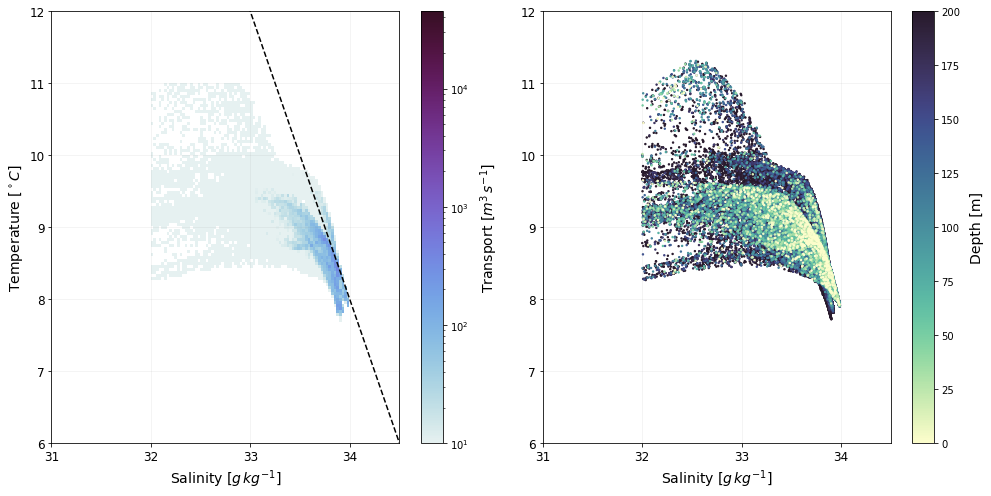

In [26]:
# all winter 2017/18
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt, temp, trans, depth = get_data_south(mydata, win_start[0], win_end[-1])

fig, ax = plt.subplots(1,2, figsize=(14,7))

bins = [np.linspace(32,34.6,100),np.linspace(6.9,11,100)]
        
H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)#,norm=LogNorm())
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax[0].pcolormesh(X, Y, H_final, cmap=cmap, norm=colors.LogNorm(vmin=10, vmax=45000))
cb = fig.colorbar(im, ax=ax[0])
cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)
ax[0].set_ylabel('Temperature [$^\circ C$]', fontsize=14)
ax[0].set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)
ax[0].set_yticks(np.arange(6,17,1))
ax[0].set_yticklabels(np.arange(6,17,1),fontsize=12)
ax[0].set_xticks(np.arange(26,35,1))
ax[0].set_xticklabels(np.arange(26,35,1),fontsize=12)
ax[0].grid(color='gray',alpha=0.1)
ax[0].set_ylim([6, 12])
ax[0].set_xlim([31, 34.5])

# add some points so we can get the equation for the line seperating the two water masses
# ax[0].scatter([33.75,34],[9,8])
x1=33.75
x2=34
y1=9
y2=8
m, b = line(x1, x2, y1, y2)
x = np.linspace(31,34.5,10)
y=m*x + b
ax[0].plot(x,y,'k--')

# second coloured by depth at the boundary
cmap = cm.cm.deep
cmap.set_bad('white')
idx = depth.argsort()
salt, temp, depth = salt[idx][::-1], temp[idx][::-1], depth[idx][::-1]
sc=plt.scatter(salt,temp,c=depth, cmap=cmap,s=2, vmin=0, vmax=200)
cb = fig.colorbar(sc, ax=ax[1])
cb.set_label('Depth [m]', labelpad=10, fontsize=14)
ax[1].set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)
ax[1].set_yticks(np.arange(6,17,1))
ax[1].set_yticklabels(np.arange(6,17,1),fontsize=12)
ax[1].set_xticks(np.arange(26,35,1))
ax[1].set_xticklabels(np.arange(26,35,1),fontsize=12)
ax[1].grid(color='gray',alpha=0.1)
ax[1].set_ylim([6, 12])
ax[1].set_xlim([31, 34.5])

plt.tight_layout()

<ipython-input-36-aa91e554a662>:28: UserWarning: The following kwargs were not used by contour: 'label'
  ax[0].contour(SA,t,spice,colors = 'gray', alpha=0.3,label='Spice')
<ipython-input-36-aa91e554a662>:54: UserWarning: The following kwargs were not used by contour: 'label'
  ax[1].contour(SA,t,spice,colors = 'gray', alpha=0.3,label='Spice')


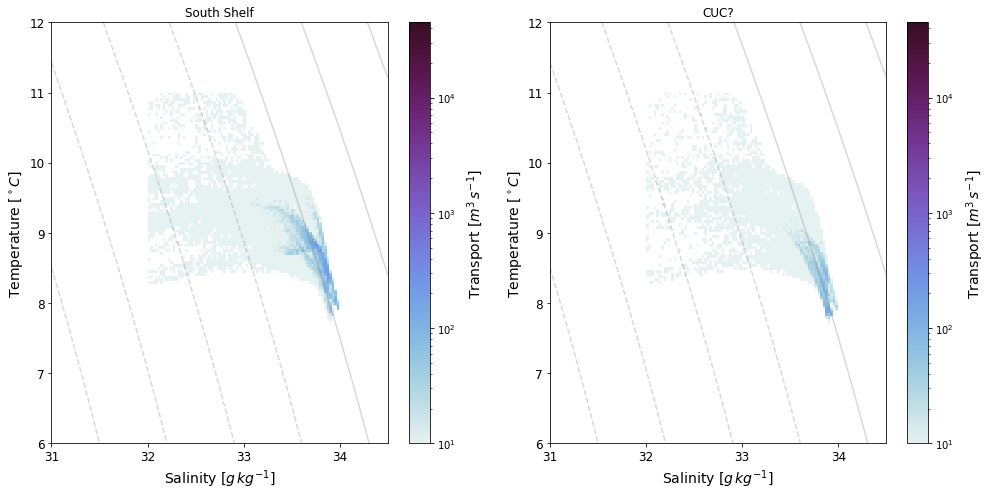

In [36]:
# winter 2017/18, south shelf and CUC only
fig, ax = plt.subplots(1,2, figsize=(14,7))
time = win_end[-1] - win_start[0] + 1 + sum_end[1] - sum_start[0] + 1
sdep = -100

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt, temp, trans= get_data_south_sep(mydata, win_start[0], win_end[-1], sdep, deep=False)

bins = [np.linspace(32,34.6,100),np.linspace(6.9,11,100)]
        
H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)#,norm=LogNorm())
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax[0].pcolormesh(X, Y, H_final, cmap=cmap, norm=colors.LogNorm(vmin=10, vmax=45000))
cb = fig.colorbar(im, ax=ax[0])
cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)
ax[0].set_ylabel('Temperature [$^\circ C$]', fontsize=14)
ax[0].set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)
ax[0].set_yticks(np.arange(6,17,1))
ax[0].set_yticklabels(np.arange(6,17,1),fontsize=12)
ax[0].set_xticks(np.arange(26,35,1))
ax[0].set_xticklabels(np.arange(26,35,1),fontsize=12)
# ax[0].grid(color='gray',alpha=0.1)
ax[0].contour(SA,t,spice,colors = 'gray', alpha=0.3,label='Spice')
ax[0].set_ylim([6, 12])
ax[0].set_xlim([31, 34.5])
ax[0].set_title('South Shelf')

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt, temp, trans= get_data_south_sep(mydata, win_start[0], win_end[-1], sdep, deep=True)

bins = [np.linspace(32,34.6,100),np.linspace(6.9,11,100)]
        
H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)#,norm=LogNorm())
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax[1].pcolormesh(X, Y, H_final, cmap=cmap, norm=colors.LogNorm(vmin=10, vmax=45000))
cb = fig.colorbar(im, ax=ax[1])
cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)
ax[1].set_ylabel('Temperature [$^\circ C$]', fontsize=14)
ax[1].set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)
ax[1].set_yticks(np.arange(6,17,1))
ax[1].set_yticklabels(np.arange(6,17,1),fontsize=12)
ax[1].set_xticks(np.arange(26,35,1))
ax[1].set_xticklabels(np.arange(26,35,1),fontsize=12)
ax[1].contour(SA,t,spice,colors = 'gray', alpha=0.3,label='Spice')
# ax[1].grid(color='gray',alpha=0.1)
ax[1].set_ylim([6, 12])
ax[1].set_xlim([31, 34.5])
ax[1].set_title('CUC?')

plt.tight_layout()